# Convolutional Neural Networks

## Project: Algorithm for a Dog Identification App 

---


![Sample Dog Output](images/sample_dog_output.png)

In this project, you will follow along on how to make dog breed classifier

### The Road Ahead


* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets



In [2]:
import numpy as np
from glob import glob


human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))


print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, I'll use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  


Number of faces detected: 1


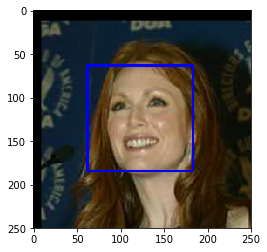

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[52])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

98% of human faces are detected.

17% of dogs are detected.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

h_counter = 0
d_counter = 0  # Initialize both a counter of human and dogs.

list_h = []
list_d = []
for i in range(len(human_files_short)):
    if face_detector(human_files_short[i]) == True: h_counter += 1 # Counter the number of TRUEs form the face_detector method,
    else: list_h.append(human_files_short[i])                                         # and increment the counter in this case. 
    
for i in range(len(dog_files_short)):
    if face_detector(dog_files_short[i]) == True: d_counter += 1 # Counter the number of Trues form the face_detector method,
    else: list_d.append(dog_files_short[i])                                        # this number represent the dogs that aren't deducted as humans

print(h_counter)
print(d_counter)

98
17


#### Now just for curiosity, I'll do some investigation about the undeducted faces, also the detected faces in the dog photos.

##### First the undeducted faces:

In [6]:
def face_print(z):
    # method to print the photos, same as the one above
    fig=plt.figure(figsize=(14, 14))
    columns = 5
    rows = 4
    
    for i, mg in enumerate(z):
        i += 1
        img = cv2.imread(mg)
        # convert BGR image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find faces in image
        faces = face_cascade.detectMultiScale(gray)

        # print number of faces detected in the image
        # print('Number of faces detected:', len(faces))

        # get bounding box for each detected face
        for (x,y,w,h) in faces:
            # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            fig.add_subplot(rows, columns, i)
        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)

    # display the image, along with bounding box
    plt.show()

In [7]:
list_d = np.array(list_d)
list_h = np.array(list_h)

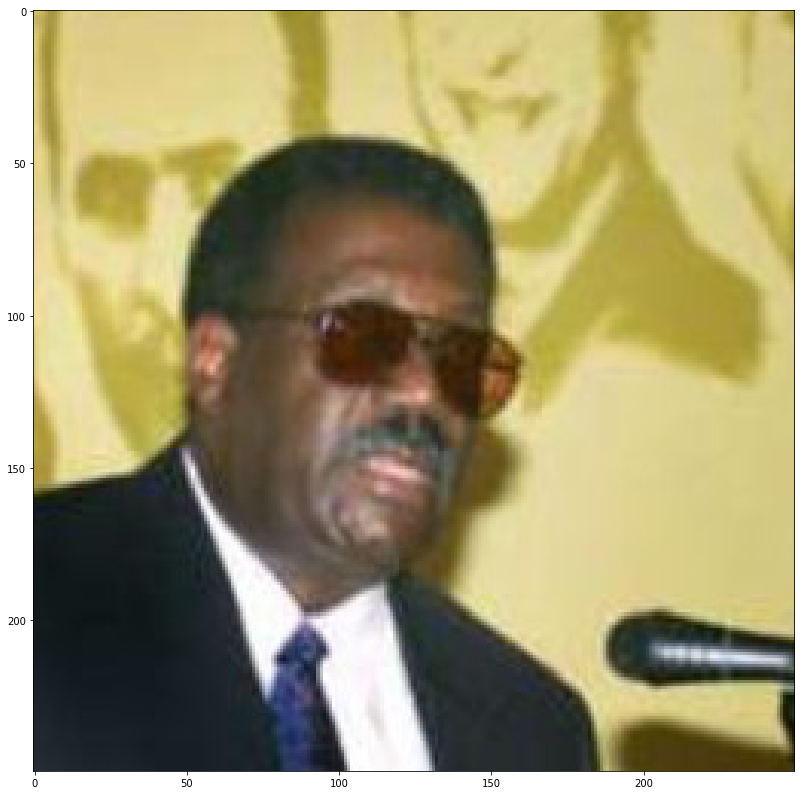

In [8]:
face_print(list_h)

### It's very strange that the algorithm did not pick up on the faces in the images.

#### Now I'll take a look at the undeducted images of dogs

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


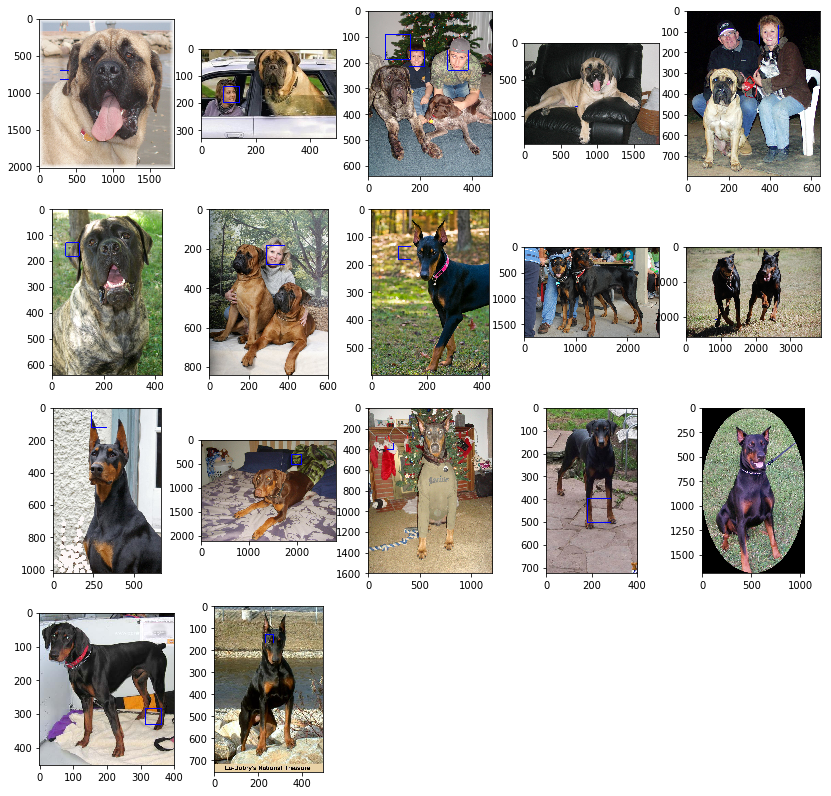

In [9]:
face_print(list_d)

### Some images have faces in it, so I wouldn't really consider them failures, others are just failuers.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I'll use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model



In [10]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 81888608.70it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

###  Making Predictions with a Pre-trained Model

In the next code cell, I'll write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.



In [1]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
                                   ])
    img = transform(img)
    img = torch.unsqueeze(img,0)
    output = VGG16(img)
    _, pred = torch.max(output, 1)    
  
    return pred

### Write a Dog Detector



In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred_class = VGG16_predict(img_path)
    if pred_class >= 151 and pred_class <= 268:
        return True
    else:
        return False

###  Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

90 % of dogs images are detected as dogs


1 % of humen images are detected as dogs

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
d_counter = 0
h_counter = 0
for i in dog_files_short:
    if dog_detector(i) == True: d_counter += 1
for i in human_files_short:
    if dog_detector(i) == True: h_counter += 1

print(d_counter,"% of dogs images are detected as dogs")
print(h_counter,"% of humen images are detected as dogs")

90 % of dogs images are detected as dogs
1 % of humen images are detected as dogs


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

In this step I will create CNN to classify dog Breeds from scratch



In [17]:
import os
from torchvision import datasets
## TODO: Specify data loaders
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets

use_cuda = torch.cuda.is_available()
num_workers = 0
batch_size = 20
transform ={'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomRotation(25),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
                               ]),
                              'valid':transforms.Compose([transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
                               ]),
                              'test':transforms.Compose([transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
                               ])}

dog_train = datasets.ImageFolder(root='/data/dog_images/train',transform=transform['train'])
dog_valid = datasets.ImageFolder(root='/data/dog_images/valid',transform=transform['valid'])
dog_test = datasets.ImageFolder(root='/data/dog_images/test',transform=transform['test'])



train_loader = torch.utils.data.DataLoader(dog_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dog_valid, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dog_test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {'train':train_loader,
           'valid': valid_loader,
           'test': test_loader}


### Display some of the images from the loader.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = (1/(2*3)) * img + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

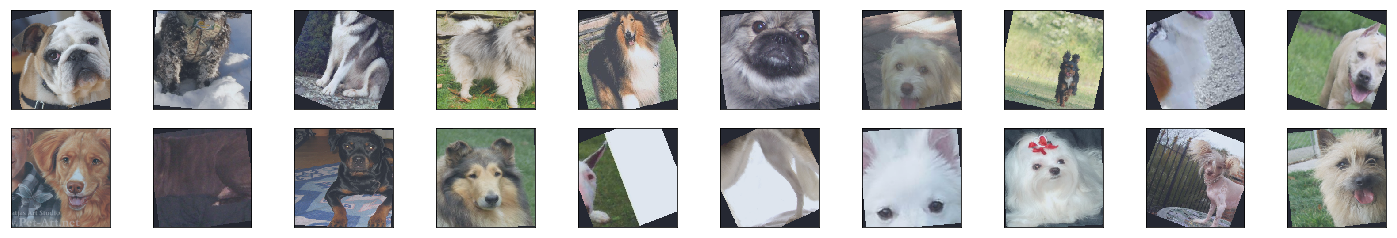

In [25]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
# convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


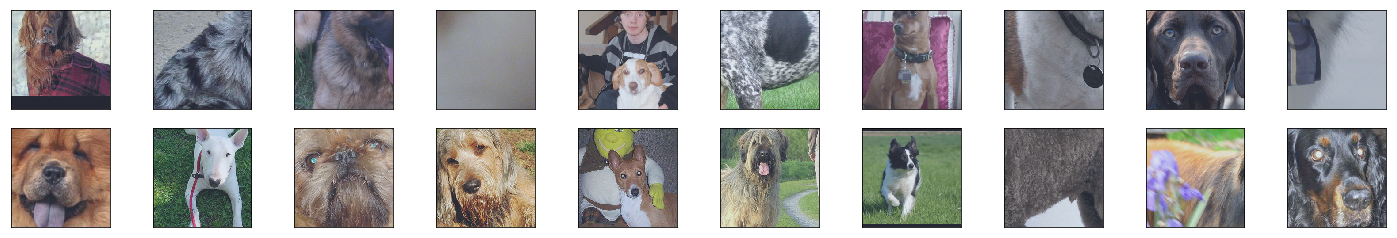

In [26]:
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images = images.numpy()
# convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


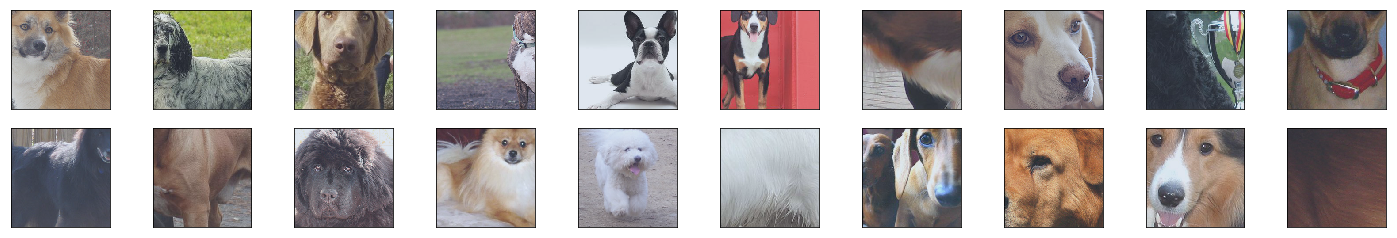

In [27]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()
# convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [28]:
print(len(train_loader))
print(len(valid_loader))

334
42


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- I did a random resize chop to size 224, also I normalize it to fit VGG because I am planning to use it for prediction.
- I did a random chop and rotation to help the NN accuracy, because image data augmentation proved to help the training.



###  Model Architecture

Create a CNN to classify dog breed.

In [2]:
# define the CNN architecture3
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # input: 224*224*3
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1 ) #224*224*16
        self.pool = nn.MaxPool2d(2, 2)
        #pool: 112*112*16
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1) #112*112*32
        #pool: 56*56*16
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1) #56*56*64
        #pool: 32*32*64
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1) #28*28*128
        #pool: 14*14*128

        #FCL
        self.fc1 = nn.Linear(14*14*128, 133)
 
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))

        x = self.pool(F.relu(self.conv4(x)))

        # flatten image input
        x = x.view(-1, 14*14*128)        
        # add dropout layer
        # add second hidden layer
        x = self.fc1(x)

        return x



# instantiate the CNN
model_scratch = Net()
print (model_scratch)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=25088, out_features=133, bias=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ I started with 4 conventional layers and maxpooling layer after each layer, and 1 fully-connected layer to predect one of the 133 classes

###  Specify Loss Function and Optimizer

in the next cell, I'll specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [3]:
import torch.optim as optim


criterion_scratch = nn.CrossEntropyLoss()


optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.025)



In [31]:
loaders = {'train':train_loader,
           'valid': valid_loader,
           'test': test_loader}

###  Train and Validate the Model


In [32]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.to('cuda'), target.to('cuda')
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.to('cuda'), target.to('cuda')
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [314]:
# train the model
model_scratch = train(21, loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'mode1l_scratch.pt')

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 3.817332 	Validation Loss: 3.994675
Validation loss decreased (inf --> 3.994675).  Saving model ...
Epoch: 2 	Training Loss: 3.767670 	Validation Loss: 4.002237
Epoch: 3 	Training Loss: 3.691598 	Validation Loss: 4.006469
Epoch: 4 	Training Loss: 3.652674 	Validation Loss: 4.114274
Epoch: 5 	Training Loss: 3.585432 	Validation Loss: 4.027638
Epoch: 6 	Training Loss: 3.527893 	Validation Loss: 4.073727
Epoch: 7 	Training Loss: 3.482253 	Validation Loss: 4.027990
Epoch: 8 	Training Loss: 3.416155 	Validation Loss: 4.055351
Epoch: 9 	Training Loss: 3.377621 	Validation Loss: 3.963725
Validation loss decreased (3.994675 --> 3.963725).  Saving model ...
Epoch: 10 	Training Loss: 3.324858 	Validation Loss: 4.006460
Epoch: 11 	Training Loss: 3.275381 	Validation Loss: 4.033025
Epoch: 12 	Training Loss: 3.233689 	Validation Loss: 4.005313
Epoch: 13 	Training Loss: 3.190840 	Validation Loss: 4.095656
Epoch: 14 	Training Loss: 3.157285 	Validation Loss: 4.290526
Epoch: 1

In [33]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model


In [315]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [316]:
# call test function    
test(loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.990614


Test Accuracy: 13% (117/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Create CNN to predict dog breeds but this time using transfer learning





In [35]:

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets

use_cuda = torch.cuda.is_available()
num_workers = 0
batch_size = 20
transform ={'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomRotation(25),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
                               ]),
                              'valid':transforms.Compose([transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
                               ]),
                              'test':transforms.Compose([transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
                               ])}

dog_train = datasets.ImageFolder(root='/data/dog_images/train',transform=transform['train'])
dog_valid = datasets.ImageFolder(root='/data/dog_images/valid',transform=transform['valid'])
dog_test = datasets.ImageFolder(root='/data/dog_images/test',transform=transform['test'])



train_loader = torch.utils.data.DataLoader(dog_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dog_valid, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dog_test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {'train':train_loader,
           'valid': valid_loader,
           'test': test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [36]:

import torchvision.models as models
import torch.nn as nn


model_transfer = models.vgg19(pretrained=True) # load the model pretrained to save time.


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:12<00:00, 44288126.06it/s]


In [37]:
print(model_transfer.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [38]:
for x in model_transfer.features.parameters():
    x.requires_grad = False #stop the training from changing the weights of the feature layers

In [39]:
# remove the last layer in the classifier
model_transfer.classifier = nn.Sequential(*list(model_transfer.classifier.children())[:-1]) 

In [40]:
model_transfer.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
)

In [41]:
model_transfer.classifier.add_module("6", nn.Linear(4096,133)) # add new last layer with 133 outputs

In [42]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I choose VGG19 to do the dog's breed image classification, I stopped the grads from changing in the feature level, and I change the last fully-connected layer to predict 133 class instead of 1000 class.


###  Specify Loss Function and Optimizer


In [43]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr= 0.0025)



###  Train and Validate the Model



In [44]:
if use_cuda:
    model_transfer = model_transfer.to('cuda')
print(use_cuda)

True


In [ ]:
# train the model
model_transfer =  train(25, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.556074 	Validation Loss: 1.790756
Validation loss decreased (inf --> 1.790756).  Saving model ...
Epoch: 2 	Training Loss: 1.952480 	Validation Loss: 1.182509
Validation loss decreased (1.790756 --> 1.182509).  Saving model ...
Epoch: 3 	Training Loss: 1.585505 	Validation Loss: 1.038430
Validation loss decreased (1.182509 --> 1.038430).  Saving model ...
Epoch: 4 	Training Loss: 1.459008 	Validation Loss: 0.964366
Validation loss decreased (1.038430 --> 0.964366).  Saving model ...
Epoch: 5 	Training Loss: 1.351333 	Validation Loss: 0.935441
Validation loss decreased (0.964366 --> 0.935441).  Saving model ...
Epoch: 6 	Training Loss: 1.319573 	Validation Loss: 0.901578
Validation loss decreased (0.935441 --> 0.901578).  Saving model ...
Epoch: 7 	Training Loss: 1.275779 	Validation Loss: 0.888911
Validation loss decreased (0.901578 --> 0.888911).  Saving model ...
Epoch: 8 	Training Loss: 1.219185 	Validation Loss: 0.879810
Validation loss decreased (0.88891

### Test the Model



In [45]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [25]:
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.915118


Test Accuracy: 74% (626/836)


In [296]:


# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in dog_train.classes]

def predict_breed_transfer(img_path):
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
                                   ])
    img = transform(img)
    img = torch.unsqueeze(img,0)
    if use_cuda:
                    img = img.to('cuda')
    output = model_transfer(img)
    _, pred = torch.max(output, 1)    
    output = class_names[pred]
    
    
    return print(output.replace("'",""), end=" ")

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write algorithm  that's return the following:

- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.



### Write your Algorithm

In [4]:

def run_app(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img) 
    plt.show()
    if face_detector(img_path) == True:
        print  ("A human face dedected, and it's looks like a",end=" "),predict_breed_transfer(img_path), print("dog")
    elif dog_detector(img_path) == True:

        print("A dog dedected in the image and, it's breed is", end=" " ), predict_breed_transfer(img_path)
        
    else:
        return print('The image has no human or dog in it.')


---
<a id='step6'></a>
## Step 6: Test Your Algorithm



###  Test Your Algorithm on Sample Images!


__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__

- The training time is very short, I would train it more if I want a better result 
- I need more images of dogs and human to improve the accuracy, what I have know is very small dataset.
- Test other models and compare the accuracy and pick the best one for this task.

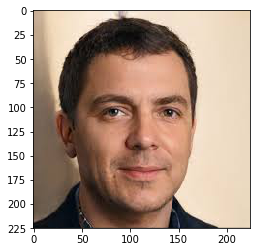

A human face dedected, and it's looks like a Basenji dog


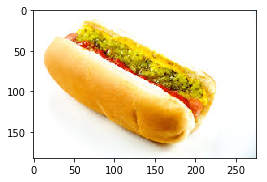

The image has no human or dog in it.


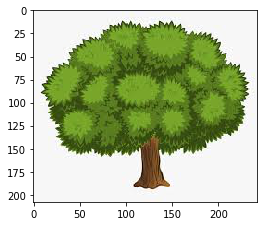

The image has no human or dog in it.


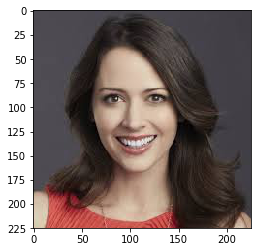

A human face dedected, and it's looks like a Papillon dog


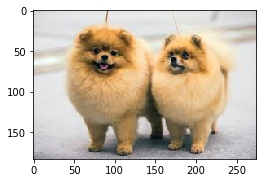

A dog dedected in the image and, it's breed is Pomeranian 

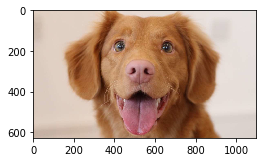

A human face dedected, and it's looks like a Nova scotia duck tolling retriever dog


In [313]:
image_dir = 'test_images/'
image_path = os.listdir(test_image_dir)
for file in image_path:
    file_path = image_dir + file
    run_app(file_path)